In [1]:
import os
os.chdir("../../")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from bs4 import BeautifulSoup
from tqdm import tqdm

## Compile

In [2]:
target_dir = os.getcwd() + "/data/text/pacific/"
pac_dir = os.getcwd() + "/../pacnews/"

for file in os.listdir(pac_dir):
    file = pac_dir + file
    if "Factiva" in file and ".txt" in file:
        new_file_name = (file.replace("Factiva-", "")
                             .replace("2023", "")
                             .replace(r"(", "")
                             .replace(r")", "")
                             .replace(" ", ""))    
        os.rename(file, new_file_name)
        
filepaths = [pac_dir + file for file in os.listdir(pac_dir) if ".txt" in file]

Converting RTF file to TXT by following commands on Mac:
`textutil -convert txt *.rtf`

In [3]:
news_info = {"title": [], "date": [], "news": []}
for fp in filepaths: 
    with open(fp, 'r') as file:
        text = file.read()
        entries = text.split("\x0c")
        for idx, entry in enumerate(entries):
            entry_lst = entry.strip().split("\n\n")
            title = entry_lst[0]
            date = entry_lst[1].split("\n")[1]
            if "words" in date:
                date = entry_lst[1].split("\n")[2]
            entry_length = len(entry_lst)
            if idx == len(entries) - 1:
                content = "".join((entry_lst[i]) for i in range(entry_length)
                                  if i > 1 and i < entry_length - 5)
            else:
                content = "".join((entry_lst[i]) for i in range(entry_length)
                                  if i > 1 and i < entry_length - 2)
            news_info["title"].append(title)
            news_info["date"].append(date)
            news_info["news"].append(content)

In [4]:
news_df = pd.DataFrame(news_info)
news_df["date"] = pd.to_datetime(news_df["date"])
news_df = (news_df.drop_duplicates()
                  .sort_values(by="date", ascending=True)
                  .reset_index(drop=True))
news_df["news"] = news_df["news"]

In [5]:
unique_idx = news_df[["title"]].drop_duplicates().index
news_df = news_df.iloc[unique_idx].reset_index(drop=True)
news_df["location"] = news_df["news"].apply(
    lambda x: "".join(i for i in x.split("--")[0].split(",")[:-1]))
news_df.to_csv(target_dir+"/pac_news_before_2021.csv", encoding="utf-8")

In [6]:
from src.text.epu import EPU

In [7]:
pac_epu = EPU(target_dir+"/pac_news_before_2021.csv")

In [8]:
pac_epu.get_epu_category()
pac_stat = pac_epu.get_epu_stats().fillna(0)

In [10]:
pe = EPU(target_dir+"pac_news_2020-23.csv")
pe.get_epu_category()

In [11]:
pe_stat = pe.get_epu_stats()
pe_stat["z_score"] = pe_stat["ratio"]/pac_epu.std

In [14]:
scaling_factor = 100/pe_stat["z_score"].mean()
pe_stat["epu_index"] = pe_stat["z_score"] * scaling_factor

<Axes: xlabel='date'>

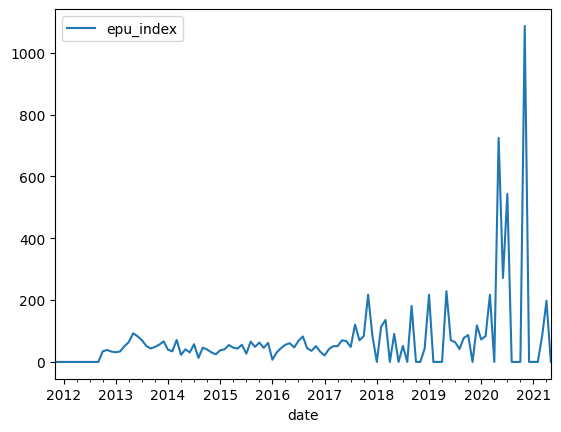

In [15]:
pac_stat["epu_index"] = pac_stat["z_score"] * scaling_factor
pac_stat.plot(x="date", y="epu_index")

<Axes: xlabel='date'>

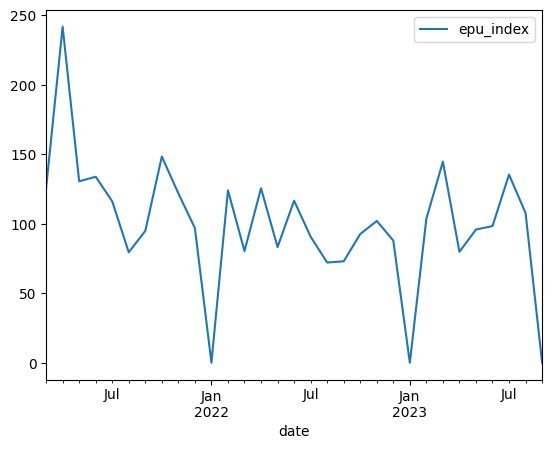

In [16]:
pe_stat.plot(x="date", y="epu_index")

## Scraping

In [2]:
url_info = {"url": [], "title": [], "date": [], "category": []}
page_range = range(1, 421)

with tqdm(total=len(page_range)) as pbar:
    for i in page_range:
        content = load_page("https://pina.com.fj/category/news/page/" + str(i),
                            5)
        soup = BeautifulSoup(content)
        for item in soup.find_all(
                class_="td_module_10 td_module_wrap td-animation-stack"):
            title = item.find("h3").text
            url = item.find("h3").find("a")["href"]
            date = item.find(class_="td-post-date")
            category = item.find(class_="td-post-category")
            url_info["url"].append(url)
            url_info["title"].append(title)
            url_info["date"].append(date.text)
            url_info["category"].append(category.text)
        pbar.update(1)

100%|██████████████████████████████████████████████████████████████████████████| 420/420 [24:55<00:00,  3.56s/it]


In [6]:
pac_urls = pd.DataFrame(url_info).drop_duplicates().reset_index(drop=True)
pac_urls["date"] = pd.to_datetime(pac_urls["date"])

target_dir = os.getcwd() + "/data/text/pac/"
if not os.path.exists(target_dir):
    os.makedirs(target_dir)
    pac_urls.to_csv(target_dir + "pac_news_urls.csv", encoding="utf-8")

In [41]:
def extract_news_pac(url: str):
    content = load_page(url, 5)
    soup = BeautifulSoup(content)
    news = soup.find(class_="td-post-content tagdiv-type").text
    tags_lst = soup.find(class_="td-post-source-tags").find_all("li")
    tags = "".join(i.text.lower() + " " for i in tags_lst if i.text.lower() != "tags")
    return [url, news, tags]

In [42]:
from concurrent.futures import ThreadPoolExecutor, as_completed, ProcessPoolExecutor
import multiprocessing

max_workers = multiprocessing.cpu_count() + 4
output = []
urls = pac_urls.url.tolist()

with tqdm(total=len(urls), unit="pages") as pbar:
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        future_to_url = {
            executor.submit(extract_news_pac, url): url
            for url in urls
        }
        for future in as_completed(future_to_url):
            url = future_to_url[future]
            try:
                data = future.result()
            except Exception as exc:
                print('%r generated an exception: %s' % (url, exc))
            else:
                output.append(data)
                pbar.update(1)

100%|█████████████████████████████████████████████████████████████████████| 4200/4200 [50:40<00:00,  1.38pages/s]


In [50]:
pac_news = pd.DataFrame(output, columns=["url", "news", "tag"])
pac_news["news"] = pac_news["news"].str.replace("\n", "")
pac_news.to_csv(target_dir+"pac_news_2020-23.csv", encoding="utf-8")